## Sagemaker Exercise

**Part 1:** This exercise. Let's explore a toy dataset (iris), train, deploy and test a ML model, using XGBoost</n>

**Part 2:** After training your first ML model using SageMaker, now it's time to optimize it using Automatic Model Tuning</n>

**Part 3:** Ah, you don't need to do real-time predictions, no problem. Let's do Batch Predictions</n>

**Part 4:** Finally, let's use SageMaker Model Monitoring to get some info from the real-time endpoint

## Part 1/4 - Train Deploy Test a multiclass model using SageMaker Built-in XGBoost

This exercise is about executing all the steps of the Machine Learning development pipeline, using some features SageMaker offers. We'll use here a public dataset called iris. Iris is a toy dataset and this is a very simple example. The idea here is to focus on the SageMaker features and not on a complex scenario. Let's see how SageMaker can accelerate your work and avoid wasting your time with tasks that aren't related to your business.
</n>

SageMaker library 2.0+ is required!

### Import the dataset and visualize it

In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn import datasets

sns.set(color_codes=True)

%matplotlib inline

In [5]:
iris = datasets.load_iris()

X = iris.data
y=iris.target

dataset = np.insert(iris.data, 0, iris.target, axis=1)

df = pd.DataFrame(data=dataset, columns=['iris_id'] + iris.feature_names)
df['species'] = df['iris_id'].map(lambda x: 'setosa' if x == 0 else 'versicolor' if x == 1 else 'virginica')

df.tail()

,iris_id,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
145,2.0,6.7,3.0,5.2,2.3,virginica
146,2.0,6.3,2.5,5.0,1.9,virginica
147,2.0,6.5,3.0,5.2,2.0,virginica
148,2.0,6.2,3.4,5.4,2.3,virginica
149,2.0,5.9,3.0,5.1,1.8,virginica


In [7]:
df.describe()

,iris_id,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,1.000000,5.843333,3.057333,3.758000,1.199333
std,0.819232,0.828066,0.435866,1.765298,0.762238
min,0.000000,4.300000,2.000000,1.000000,0.100000
25%,0.000000,5.100000,2.800000,1.600000,0.300000
50%,1.000000,5.800000,3.000000,4.350000,1.300000
75%,2.000000,6.400000,3.300000,5.100000,1.800000
max,2.000000,7.900000,4.400000,6.900000,2.500000


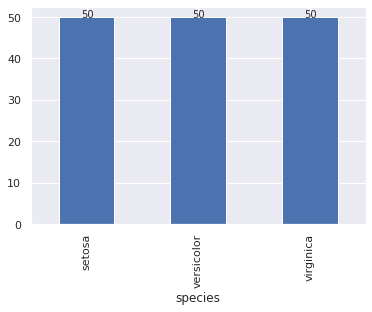

In [8]:
# check class distribution

ax = df.groupby(df['species'])['species'].count().plot(kind='bar')
x_offset = -0.05
y_offset = 0
for p in ax.patches:
    b = p.get_bbox()
    val = "{}".format(int(b.y1 + b.y0))
    ax.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 + y_offset))

<AxesSubplot:>

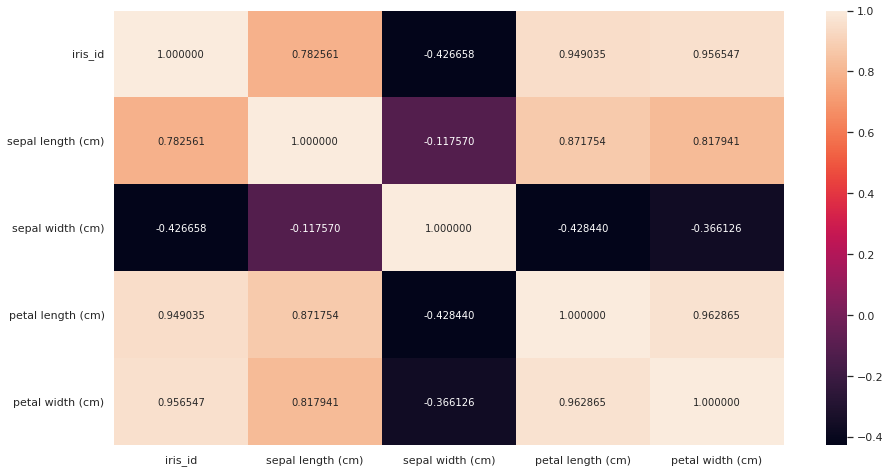

In [9]:
# check correlation 

corr = df.corr()

f, ax = plt.subplots(figsize = (15, 8))
sns.heatmap(corr, annot = True, fmt="f", 
            xticklabels=corr.columns.values,
           yticklabels=corr.columns.values, 
           ax=ax)


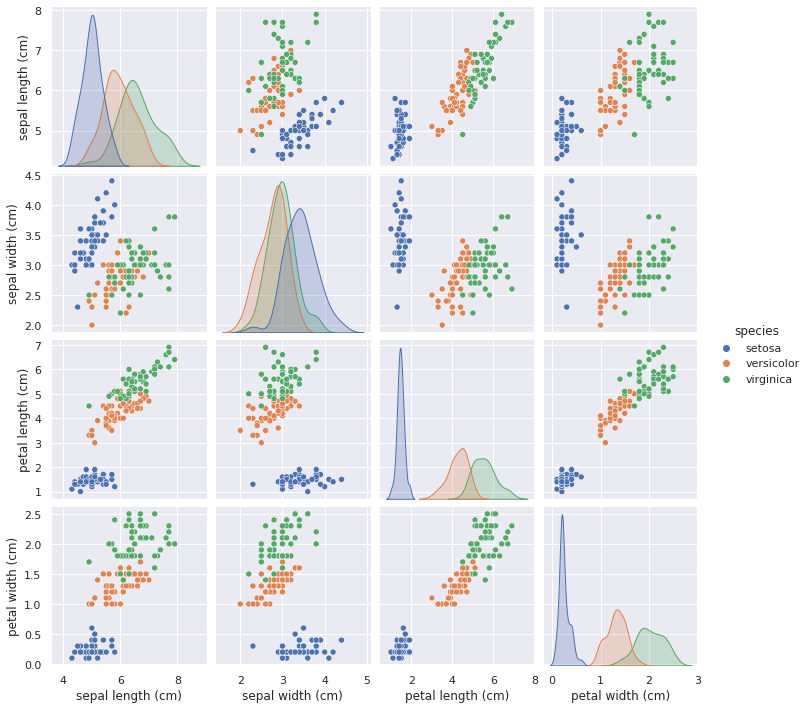

In [12]:
# Pairplot & Histograms

sns.pairplot(df.drop(['iris_id'], axis=1), hue="species", height=2.5, diag_kind="kde")

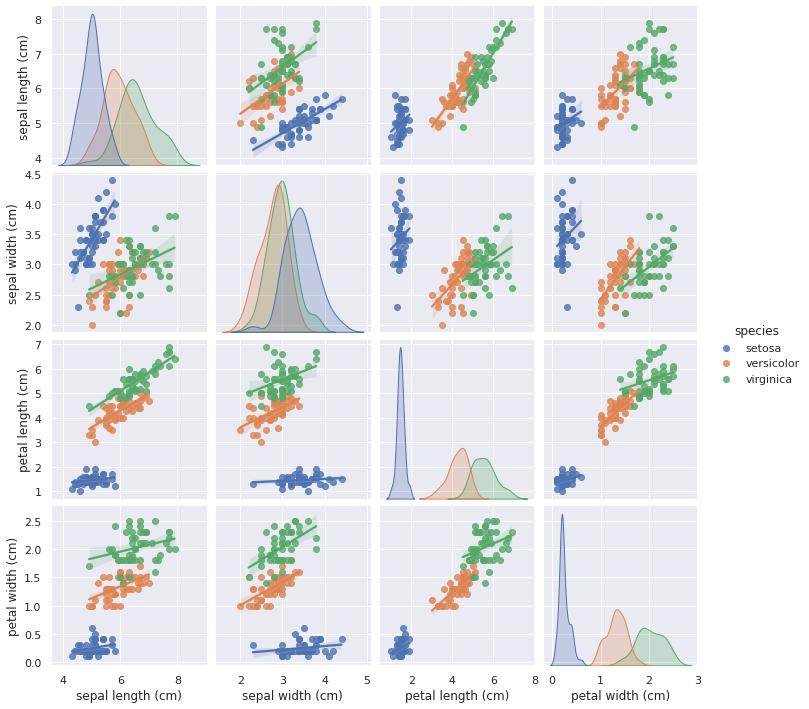

In [13]:
# pairplot  and Histogram with regression line

sns.pairplot(df.drop(['iris_id'], axis=1), hue="species", height=b2.5, diag_kind="kde", kind="reg")

/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using silverman for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/seaborn/distributions.py:1718: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please update your code.
  warnings.warn(msg, UserWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/seaborn/_deco

Text(0.5, 0, 'species')

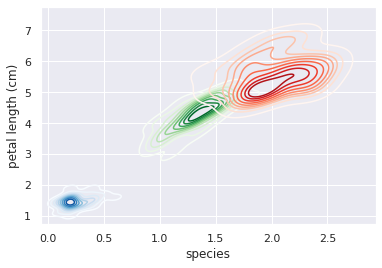

In [15]:
# Fit a plot a kernel density estimate

tmp_df = df[(df.iris_id==0.0)]
sns.kdeplot(tmp_df['petal width (cm)'], tmp_df['petal length (cm)'], bw='silverman', cmap='Blues', shade = False, shade_lowest=False)

tmp_df = df[(df.iris_id==1.0)]
sns.kdeplot(tmp_df['petal width (cm)'], tmp_df['petal length (cm)'], bw='silverman', cmap='Greens', shade = False, shade_lowest=False)


tmp_df = df[(df.iris_id==2.0)]
sns.kdeplot(tmp_df['petal width (cm)'], tmp_df['petal length (cm)'], bw='silverman', cmap='Reds', shade = False, shade_lowest=False)

plt.xlabel('species')

### Train Test Split

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=123, stratify=y)
yX_train = np.column_stack((y_train, X_train))
yX_test = np.column_stack((y_test, X_test))
np.savetxt("iris_train.csv", yX_train, delimiter=',', fmt='%0.3f')
np.savetxt("iris_test.csv", yX_test, delimiter=',', fmt='%0.3f')

### Train model with Built-in XGBoost

In [21]:
import sagemaker
import boto3
from sagemaker import get_execution_role
from sklearn.model_selection import train_test_split

role = get_execution_role()

prefix = 'mlops/iris'

sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
assert(sagemaker.__version__ >= "2.0")

### Upload train test dataset and model to s3 bucket 

In [22]:
input_train = sagemaker_session.upload_data(path='iris_train.csv', key_prefix='%s/data' % prefix)
input_test = sagemaker_session.upload_data(path='iris_test.csv', key_prefix='%s/data' % prefix)

In [23]:
train_data = sagemaker.inputs.TrainingInput(s3_data=input_train, content_type="csv")
test_data = sagemaker.inputs.TrainingInput(s3_data=input_test, content_type="csv")

In [32]:
# get the URI for new container
container_uri = sagemaker.image_uris.retrieve('xgboost', boto3.Session().region_name, version='1.0-1')

# create the estimator
xgb= sagemaker.estimator.Estimator(container_uri, 
                                   role, 
                                   instance_count=1, 
                                   instance_type='ml.m4.xlarge',
                                   output_path='s3://{}/{}/output'.format(bucket, prefix),
                                   sagemaker_session=sagemaker_session)

# set hyper parameters
xgb.set_hyperparameters(eta=0.1,
                       max_depth=10,
                       gamma=4,
                       num_classes=len(np.unique(y)),
                       alpha=10,
                       min_chiild_weight=6,
                       silent=0,
                       objective='multi:softmax',
                       num_round=30)

### Train Model

In [33]:
%%time

xgb.fit({'train': train_data, 'validation': test_data, })

2022-08-29 18:17:37 Starting - Starting the training job...
2022-08-29 18:18:01 Starting - Preparing the instances for trainingProfilerReport-1661797057: InProgress
.........
2022-08-29 18:19:22 Downloading - Downloading input data...
2022-08-29 18:20:02 Training - Downloading the training image......
2022-08-29 18:21:02 Uploading - Uploading generated training modelINFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value multi:softmax to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
[18:20:52] 100x4 matrix with 400 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=

## Deploy the model and create an endpoint for it
</n>
The following action will:
</n>

*Get the assets from the job we just ran and then create an input in the Models Catalog*</n>

*create a endpoint configuration (a metadata for our final endpoint)*</n>

*create an endpoint, which is our model wrapped in a format of a WebService*</n>

After that we'll be able to call our deployed endpoint for doing predictions

In [34]:
%%time

#Enable .log capturing in the endpoint

data_capture_configuration = sagemaker.model_monitor.data_capture_config.DataCaptureConfig(
                                        enable_capture=True,
                                        sampling_percentage=100,
                                        destination_s3_uri="s3://{}/{}/monitoring".format(bucket, prefix),
                                        sagemaker_session=sagemaker_session)

xgb_predictor = xgb.deploy(initial_instance_count=1,
                          instance_type='ml.m4.xlarge',
                          data_capture_config=data_capture_configuration)

---------------!CPU times: user 207 ms, sys: 11.1 ms, total: 218 ms
Wall time: 7min 32s


### Setup the monitor

In [37]:
from sagemaker.serializers import CSVSerializer
from sklearn.metrics import f1_score
csv_serializer = CSVSerializer()

endpoint_name = xgb_predictor.endpoint_name
nodel_name = boto3.client('sagemaker').describe_endpoint_config(EndpointConfigName=endpoint_name
                                                               )['ProductionVariants'][0]['ModelName']

!echo $model_name > model_name.txt
!echo $endpoint_name > endpoint_name.txt
xgb_predictor.serializer = csv_serializer

### Let's do a basic test with the deployed endpoint
In this test, we'll use a helper object called predictor. This object is always returned from a Deploy call. The predictor is just for testing purposes and we'll not use it inside our real application.

In [39]:
predictions_test = [float(xgb_predictor.predict(x).decode('utf-8')) for x in X_test]
score = f1_score(y_test, predictions_test, labels=[0.0,1.0, 2.0], average='micro')

print("F1 Score: %.2f"%(score*100.0))

F1 Score: 94.00
